In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Import relativedelta to add/subtract months from a date
# Reference: https://stackoverflow.com/questions/65621298/how-do-i-add-a-month-to-my-date-object-in-datetime-python
from dateutil.relativedelta import relativedelta as rd

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Explore Database

In [10]:
inspector = inspect(engine)
tables = inspector.get_table_names()
for table in tables:
    print(f'** Table: {table}')
    columns = inspector.get_columns(table)
    for c in columns:
        print(c['name'], c["type"])

** Table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
** Table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date

('2017-08-23',)

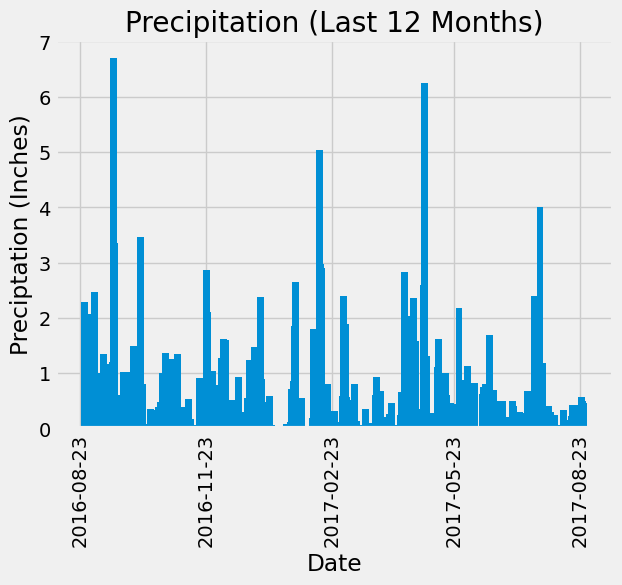

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
end_date = last_date[0]

# Calculate the date one year from the last date in data set without passing date as a variable
start_date = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)

# Alternate method pasing the date as a variable. This uses strptime and relativedelta.
# Reference for strptime - https://www.digitalocean.com/community/tutorials/python-string-to-datetime-strptime
# start_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date() - rd(months=12)

# Perform a query to retrieve the date and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= str(start_date)).\
    filter(measurement.date <= end_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
conn = engine.connect()
precip_df = pd.read_sql(precip_data.statement, con=conn, parse_dates=['date'])
precip_df = precip_df.rename(columns={'date': 'Date', 'prcp': 'Precipitation'})

# Sort the dataframe by date
precip_df.sort_values('Date').reset_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

# Set ticks on x to be every 3 months
tick_dates = [(start_date + rd(months=int(3*value))) for value in np.arange(5)]
x = precip_df['Date']
y = precip_df['Precipitation']

plt.bar(x, y, width=5.0, align='edge')
plt.xticks(tick_dates, rotation="vertical")
plt.xlabel('Date')
plt.ylabel('Preciptation (Inches)')
plt.title('Precipitation (Last 12 Months)')
# plt.legend([y.name], loc='upper center') # didn't include this as I didn't think it's necessary with the title
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df[['Precipitation']].describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.station).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).group_by(measurement.station).all()

[(54.0, 85.0, 71.66378066378067)]

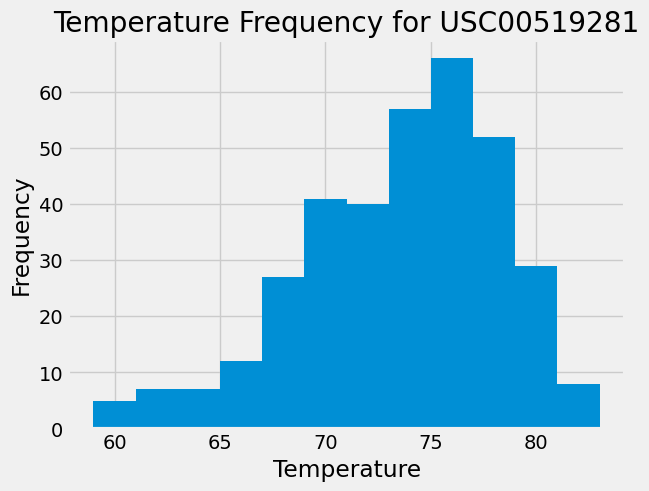

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).\
    filter(measurement.date >= str(start_date)).filter(measurement.date <= end_date).\
    filter(measurement.station == most_active_station)

# Save as a dataframe to easily plot histogram
temp_df = pd.read_sql(temp_data.statement, con=conn)
temp_df = temp_df.rename(columns={'tobs': "Temperature"})

plt.hist(temp_df, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Frequency for {most_active_station}')
plt.show()

# Close Session

In [18]:
# Close Session
session.close()